In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\XRP Historical Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.8 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
48/48 [==============================] - 4s 10ms/step - loss: 0.0128
Epoch 2/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 9.9582e-04
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 9.1176e-04
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 8.5253e-04
Epoch 7/100
48/48 [==============================] - 0s 10ms/step - loss: 7.8034e-04
Epoch 8/100
48/48 [==============================] - 0s 10ms/step - loss: 7.8662e-04
Epoch 9/100
48/48 [==============================] - 0s 10ms/step - loss: 7.4871e-04
Epoch 10/100
48/48 [==============================] - 0s 9ms/step - loss: 8.2691e-04
Epoch 11/100
48/48 [==============================] - 0s 10ms/step - loss: 6.9073e-04
Epoch 12/100
48/48 [==============================] - 0s 9ms/step - loss: 6.

<h2> Predict Price for next 30 days </h2>

Predicted XRP prices for the next 30 days:
[ 0.49352145  0.47085212  0.44922121  0.42713637  0.40487172  0.38263795
  0.3605015   0.33847039  0.31653191  0.29466564  0.27285017  0.25107188
  0.22931531  0.20756457  0.18580458  0.16402095  0.14219984  0.12032789
  0.0983922   0.07638034  0.05428031  0.03208046  0.00976964 -0.01266296
 -0.03522782 -0.05793496 -0.08079412 -0.10381459 -0.12700524 -0.15037451]


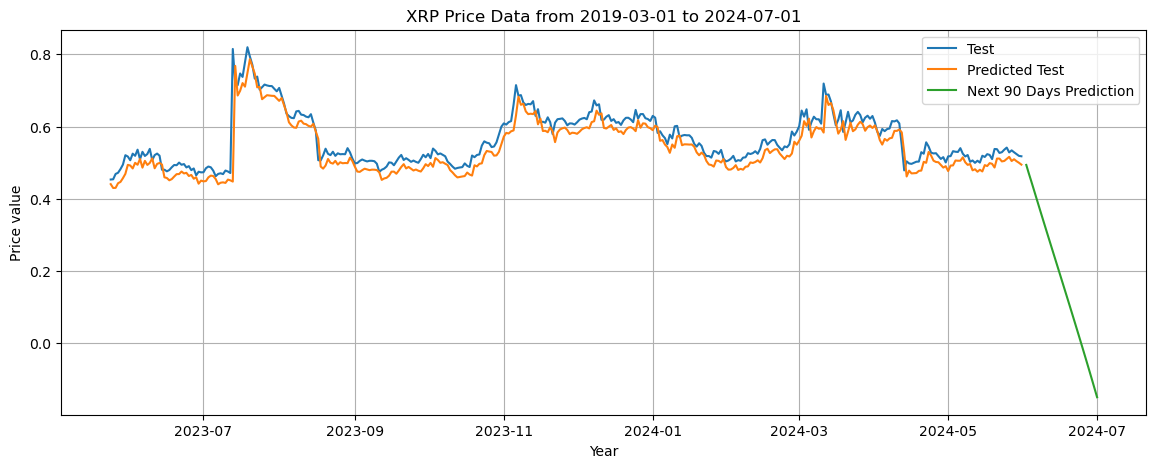

In [2]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted XRP prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted XRP prices for the next 60 days:
[ 0.49352145  0.47085212  0.44922121  0.42713637  0.40487172  0.38263795
  0.3605015   0.33847039  0.31653191  0.29466564  0.27285017  0.25107188
  0.22931531  0.20756457  0.18580458  0.16402095  0.14219984  0.12032789
  0.0983922   0.07638034  0.05428031  0.03208046  0.00976964 -0.01266296
 -0.03522782 -0.05793496 -0.08079412 -0.10381459 -0.12700524 -0.15037451
 -0.17393067 -0.1976813  -0.22163357 -0.24579432 -0.27016973 -0.29476562
 -0.31958722 -0.34463899 -0.36992527 -0.3954493  -0.42121363 -0.44722047
 -0.47347091 -0.49996558 -0.52670399 -0.55368497 -0.5809061  -0.60836452
 -0.63605609 -0.66397553 -0.69211662 -0.72047235 -0.74903423 -0.77779282
 -0.80673748 -0.83585614 -0.86513636 -0.89456362 -0.92412295 -0.9537979 ]


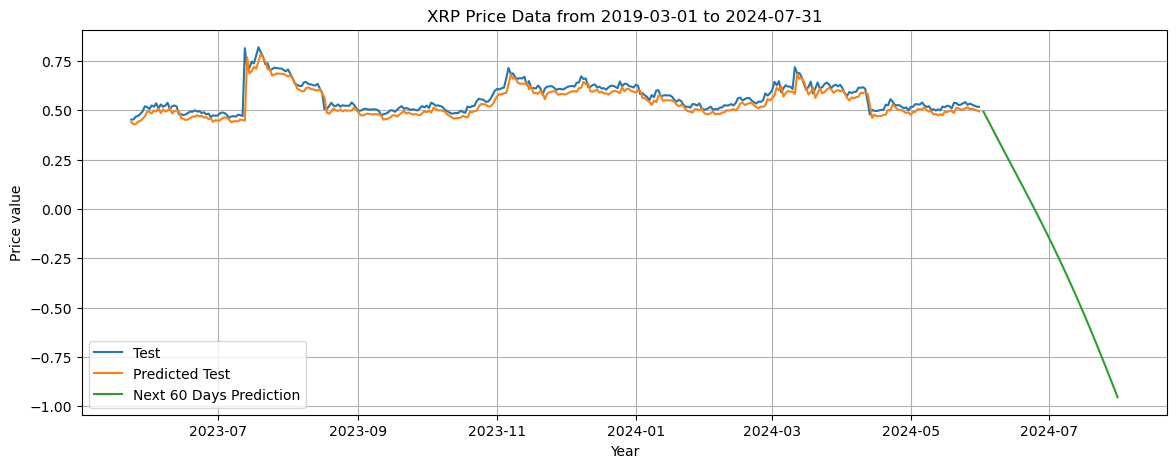

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted XRP prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted XRP prices for the next 90 days:
[ 0.49352145  0.47085212  0.44922121  0.42713637  0.40487172  0.38263795
  0.3605015   0.33847039  0.31653191  0.29466564  0.27285017  0.25107188
  0.22931531  0.20756457  0.18580458  0.16402095  0.14219984  0.12032789
  0.0983922   0.07638034  0.05428031  0.03208046  0.00976964 -0.01266296
 -0.03522782 -0.05793496 -0.08079412 -0.10381459 -0.12700524 -0.15037451
 -0.17393067 -0.1976813  -0.22163357 -0.24579432 -0.27016973 -0.29476562
 -0.31958722 -0.34463899 -0.36992527 -0.3954493  -0.42121363 -0.44722047
 -0.47347091 -0.49996558 -0.52670399 -0.55368497 -0.5809061  -0.60836452
 -0.63605609 -0.66397553 -0.69211662 -0.72047235 -0.74903423 -0.77779282
 -0.80673748 -0.83585614 -0.86513636 -0.89456362 -0.92412295 -0.9537979
 -0.98357066 -1.01342286 -1.04333538 -1.07328761 -1.10325809 -1.13322452
 -1.16316419 -1.19305329 -1.2228678  -1.25258319 -1.28217474 -1.31161701
 -1.34088546 -1.36995437 -1.3987987  -1.42739402 -1.45571611 -1.48374085
 -1.51144

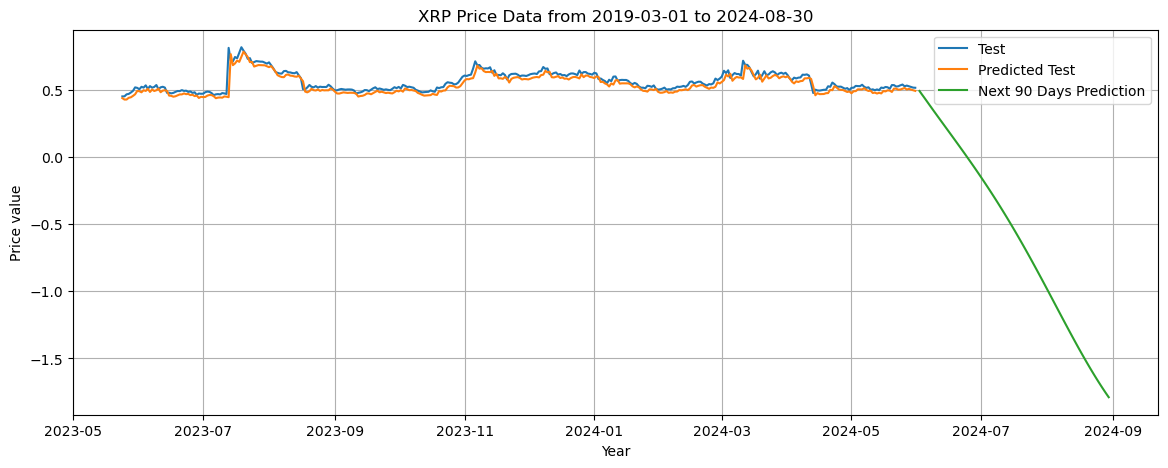

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted XRP prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()